In [41]:
%pip install yfinance
%pip install pandas

In [42]:
import yfinance as yf
import pandas as pd
import datetime

def fetch_data():

    glenData = yf.Ticker("GLEN.L")
    camlData = yf.Ticker("CAML.L")

    end_date = datetime.datetime.today().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.today() - datetime.timedelta(days=10*365)).strftime("%Y-%m-%d")

    glenDataDF = pd.DataFrame(glenData.history(start=start_date,end=end_date))
    camlDataDF = pd.DataFrame(camlData.history(start=start_date,end=end_date))

    return glenDataDF,camlDataDF

In [43]:
from math import sqrt, log
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def regress_data(camlDataDF,glenDataDF):

    glenDataDF = pd.DataFrame({'GLEN':glenDataDF["Close"].values})
    camlDataDF = pd.DataFrame({'CAML':camlDataDF["Close"].values})

    data = pd.concat([glenDataDF, camlDataDF], axis=1)
    data.dropna(axis=0, how='any',inplace=True)
    independentStock = 'CAML'
    dependentStock = 'GLEN'

    regressionModel = LinearRegression()
    regressionModel.fit(data[independentStock].values.reshape(-1,1),data[dependentStock].values)
    print('parameters: %.7f, %.7f' %(regressionModel.intercept_, regressionModel.coef_))

    yfit = regressionModel.coef_ * data[independentStock] + regressionModel.intercept_
    y_residual = data[dependentStock] - yfit

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].set_title(independentStock +' vs ' +dependentStock)
    ax[0].plot(data)
    ax[1].set_title('Regression Residual')
    ax[1].plot(y_residual)

    print(ts.adfuller(y_residual, 1) )

    hedgingRatio = pearsonr(data[independentStock], data[dependentStock])[0]
    print(hedgingRatio)

    plt.show()
    
    return hedgingRatio

parameters: -93.4547525, 1.6362008
(-4.172479826701086, 0.0007332547230690424, 1, 1513, {'1%': -3.4346794310731665, '5%': -2.8634521717811046, '10%': -2.567788014921572}, 10586.362746096385)
0.9085758135384709


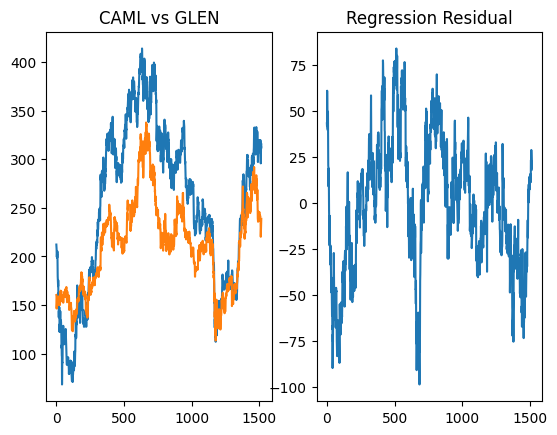

In [44]:
glenDataDF,camlDataDF = fetch_data()

noOfElements = len(glenDataDF["Close"])
glenTraingDataDF = glenDataDF.iloc[:-1*int(0.4*noOfElements)]
noOfElements = len(camlDataDF["Close"])
camlTraingDataDF = camlDataDF.iloc[:-1*int(0.4*noOfElements)]

hedgingRatio = regress_data(camlTraingDataDF,glenTraingDataDF)

In [45]:
from math import log,sqrt

# A is caml B is glen
# For each stock of caml we buy <hedgingRatio> amount of glen
def spread(a,b,hedgingRatio):
    return log(a)-hedgingRatio*log(b)

In [46]:
def check_positions(positions, hedgingRatio, zScore,prev_zScore, camlTestingDataDF,glenTestingDataDF, x):

    daily_pnl = 0

    for p in positions:

        if p["open"] == True:
            
            if p["type"] == "short":

                pnl_glencore = p["caml_no_of_shares"] * hedgingRatio * (p["buy_price"] - glenTestingDataDF["Close"].iloc[x])
                pnl_caml = p["caml_no_of_shares"] * (camlTestingDataDF["Close"].iloc[x] - p["sell_price"])

                daily_pnl += pnl_glencore + pnl_caml

                if prev_zScore > 0 and zScore <= 0:

                    p["open"] = False

                if zScore >= 2.5 and zScore < 3:

                    p["stop_loss"] = True

                if zScore >= 3 and p["stop_loss"] == True:

                    p["open"] = False


            if p["type"] == "long":

                pnl_glencore = p["caml_no_of_shares"] * hedgingRatio * (glenTestingDataDF["Close"].iloc[x] - p["sell_price"])
                pnl_caml = p["caml_no_of_shares"] * (p["buy_price"] - camlTestingDataDF["Close"].iloc[x])

                daily_pnl += pnl_glencore + pnl_caml

                if zScore >= 0 and prev_zScore < 0:

                    p["open"] = False
    
                if zScore <= -2.5 and zScore > -3:

                    p["stop_loss"] = True

                if zScore <= -3 and p["stop_loss"] == True:

                    p["open"] = False


    return daily_pnl

In [47]:
def calculateSharpeRatio(daily_returns,risk_free_daily):

    excess_returns = daily_returns - risk_free_daily
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)

    return sharpe_ratio,sharpe_ratio_annualized

In [48]:
import numpy as np

def backtest_strategy(camlTestingDataDF,glenTestingDataDF, hedgingRatio):

    glenTestingDataDF.reset_index(inplace = True)
    camlTestingDataDF.reset_index(inplace = True)

    bankroll = 10000
    prev_zScore = 0
    positions = []
    bankrolls = []
    dates = []

    for x in range(20, min(len(camlTestingDataDF),len(glenTestingDataDF))):

        sumOfSpreads = sum([spread(camlTestingDataDF["Close"].iloc[y], glenTestingDataDF["Close"].iloc[y],hedgingRatio) for y in range(x-20,x)])
        meanSpread = sumOfSpreads/20
        sdSpread = sqrt(sum([(meanSpread-spread(camlTestingDataDF["Close"].iloc[y], glenTestingDataDF["Close"].iloc[y],hedgingRatio))**2 for y in range(x-20,x)]) / 20)
        currentSpread = spread(camlTestingDataDF["Close"].iloc[x], glenTestingDataDF["Close"].iloc[x],hedgingRatio)

        zScore = (currentSpread - meanSpread)/sdSpread

        daily_pnl = check_positions(positions,hedgingRatio, zScore,prev_zScore,camlTestingDataDF,glenTestingDataDF,x)
        bankroll += daily_pnl

        if bankroll > 0:

            if zScore >= 2:
                # short
                # sell A buy B

                stake = bankroll * 0.01
                caml_no_of_shares = stake/camlTestingDataDF["Close"].iloc[x]

                new_position = {"date":glenTestingDataDF['Date'].iloc[x],"type":"short","caml_no_of_shares":caml_no_of_shares, "buy_price":glenTestingDataDF["Close"].iloc[x],"sell_price":camlTestingDataDF["Close"].iloc[x],"open":True,"stop_loss":False}

                positions.append(new_position)

            if zScore <= -2:
                # long
                # buy A sell B
                
                stake = bankroll * 0.01
                caml_no_of_shares = stake/camlTestingDataDF["Close"].iloc[x]

                new_position = {"date":glenTestingDataDF['Date'].iloc[x],"type":"long", "caml_no_of_shares":caml_no_of_shares, "buy_price":camlTestingDataDF["Close"].iloc[x], "sell_price":glenTestingDataDF["Close"].iloc[x],"open":True,"stop_loss":False}

                positions.append(new_position)


        prev_zScore = zScore
        bankrolls.append(bankroll)
        dates.append(glenTestingDataDF["Date"].iloc[x])
        

    initial_bankroll = bankrolls[0]
    final_bankroll = bankrolls[-1]
    
    # Total ROI
    roi = (final_bankroll / initial_bankroll - 1) * 100
    
    # Annualized ROI (CAGR)
    years = 4 * 365 / 365.25
    annual_roi = ((final_bankroll / initial_bankroll) ** (1 / years) - 1) * 100
    
    # Daily returns
    daily_returns = np.array(bankrolls[1:]) / np.array(bankrolls[:-1]) - 1
    
    # Risk-free rate (UK 3M T-bill ~5.25% annually)
    risk_free_annual = 0.0525
    risk_free_daily = risk_free_annual / 252
    
    # Sharpe ratio (annualized)
    sharpe_ratio,sharpe_ratio_annualized = calculateSharpeRatio(daily_returns,risk_free_daily)
    
    # Max Drawdown
    cum_returns = np.array(bankrolls) / initial_bankroll
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min() * 100  # in %
    
    print("=== Strategy Performance Summary ===")
    print(f"Initial Bankroll: £{initial_bankroll:,.2f}")
    print(f"Final Bankroll:   £{final_bankroll:,.2f}")
    print(f"Total ROI:        {roi:.2f}%")
    print(f"Annualized ROI:   {annual_roi:.2f}%")
    print(f"Max Drawdown:     {max_drawdown:.2f}%")
    print(f"Daily Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized:.2f}")
        
    plt.plot(dates,bankrolls)
    plt.show()

=== Strategy Performance Summary ===
Initial Bankroll: £10,000.00
Final Bankroll:   £11,881.10
Total ROI:        18.81%
Annualized ROI:   4.41%
Max Drawdown:     -18.54%
Daily Sharpe Ratio: -0.01
Annualized Sharpe Ratio: -0.22


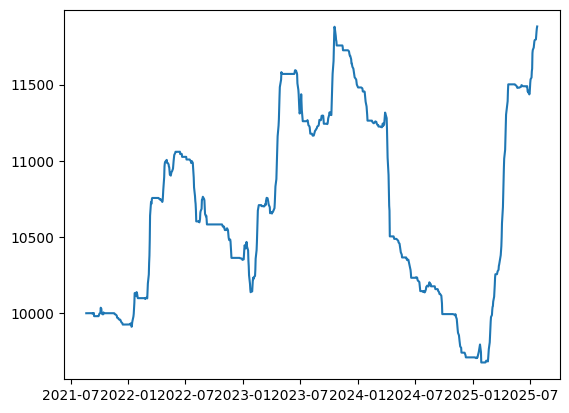

In [49]:
noOfElements = len(glenDataDF["Close"])
glenTestingDataDF = glenDataDF.iloc[int(0.6*noOfElements):]
noOfElements = len(camlDataDF["Close"])
camlTestingDataDF = camlDataDF.iloc[int(0.6*noOfElements):]

backtest_strategy(camlTestingDataDF,glenTestingDataDF, hedgingRatio)